In [ ]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
import random
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Overview
Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.
So, let's say we have the following image.

![](https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png)

And then given the above image its semantically segmentated image would be the following

![](https://lh3.googleusercontent.com/-gdUavPeOxdg/XPPXQngAnvI/AAAAAAAAAQA/yoksBterCGQGt-lv3aX4kfyMUDXTar7yACK8BGAs/s374/index4.png)

As you can see, that each pixel in the image is classified to its respective class.


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
import os 
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path
  
  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")
 
get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

## Helper Functions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np

"""Various RGB palettes for coloring segmentation labels."""
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

## Code

### 1. Implement Data Loader for training and validation

In [ ]:
import os 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tf
import cv2
import random

# You can modify this class 
class VocDataset(Dataset):
  def __init__(self, dir, color_map):

    self.height, self.width = (256,512)

    self.root=os.path.join(dir,'VOCdevkit/VOC2007')
    self.target_dir=os.path.join(self.root,'SegmentationClass')
    self.images_dir=os.path.join(self.root,'JPEGImages')
    file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
    self.color_map=color_map
    
    self.transformImg=tf.Compose([tf.ToPILImage(), tf.Resize((self.height,self.width)),
                             tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    # self.transformLabel=tf.Compose([tf.ToPILImage(), tf.Resize((self.height,self.width)), tf.ToTensor()])
    
    self.images = [self.transformImg(cv2.cvtColor(cv2.imread(os.path.join(self.images_dir , id + '.jpg')), cv2.COLOR_BGR2RGB).astype(np.uint8)) for id in self.files]

    self.segmented = [cv2.cvtColor(cv2.imread(os.path.join(self.target_dir , id + '.png')), cv2.COLOR_BGR2RGB) for id in self.files]

    self.labels = self.get_labels(self.segmented)

  def get_labels(self, masks):
    labels = []
    for seg in masks:
      label = np.zeros(seg.shape[:-1])
      for i,color in enumerate(self.color_map):
        loc = np.where(np.all(seg == color, axis=-1))
        label[loc] = i
      label = cv2.resize(label, (self.width, self.height), interpolation = cv2.INTER_NEAREST)
      labels.append(torch.tensor(label))
    return labels

  def convert_to_segmentation_mask(self,masks):
    # This function converts color channels of semgentation masks to number of classes
    # Semantic Segmentation requires a segmentation mask to be a NumPy array with the shape
    # This part is implemented for displaying colorized results in subpart 3
    # YOUR CODE HERE:

    # Implemented at the inference step
    
    return None

  def __getitem__(self, index):
    return self.images[index], self.labels[index]

  def get_batch(self):
    # YOUR CODE HERE:
    batch_size = 4
    rand = np.random.randint(0, len(self.files), size = batch_size).tolist()
    # rand = random.choices(range(len(self.files)), k = batch_size)
    im = torch.Tensor(batch_size, 3, self.height, self.width)
    lbl = torch.Tensor(batch_size, self.height, self.width)
    images = [torch.unsqueeze(self.images[i], 0) for i in rand]
    labels = [torch.unsqueeze(self.labels[i], 0) for i in rand]
    torch.cat(images, out = im, dim = 0)
    torch.cat(labels, out = lbl, dim = 0) 

    return im, lbl

  def __len__(self):
    return len(self.files)

data = VocDataset('/content', VOC_COLORMAP)

###2. Define model and training code
Implement FCN-32 model. You can use encoder as pretrained model provided by torchvision.       

In [ ]:
import torch

encoder = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', weights='VGG16_BN_Weights.DEFAULT')

class FCN32(torch.nn.Module):
  def __init__(self, n_classes, pretrained_model):
        # YOUR CODE HERE:
        super().__init__()
        self.n_class = n_classes
        # self.pretrained_net = pretrained_model
        self.pretrained_net = torch.nn.Sequential(*(list(pretrained_model.children())[:-2])[0])
        # self.pretrained_net = torch.nn.Sequential(*(list(self.pretrained_net.children())[:-5]))
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_classes, kernel_size=1)

  def forward(self, x):
        output = self.pretrained_net(x)

        score = self.bn1(self.relu(self.deconv1(output)))     # size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

fcn32_net = FCN32(len(VOC_CLASSES), encoder)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
fcn32_net.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


FCN32(
  (pretrained_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(

In [ ]:
# Model Configuration

train_set,val_set=torch.utils.data.random_split(data,[int(len(data)*0.9),round(len(data)*0.1)+1])

train_loader=DataLoader(train_set,batch_size=10,shuffle=True)
val_loader=DataLoader(val_set,batch_size=10,shuffle=False)

Learning_Rate=1e-3

optimizer = optim.Adam(params=fcn32_net.parameters(),lr=Learning_Rate)  ## TODO: Add loss function
criterion = torch.nn.CrossEntropyLoss() ## TODO: Add optimizer
n_class = 20

In [ ]:
def metrics(target, pred, n_class = 20):
    n_class = n_class
    ious = []
    for cls in range(n_class):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            ious.append(float('nan'))  
        else:
            ious.append(float(intersection) / max(union, 1))
        # print("cls", cls, pred_inds.sum(), target_inds.sum(), intersection, float(intersection) / max(union, 1))
    return ious

In [ ]:
import torch.optim as optim

epochs = 40
iters = 100
for epoch in range(epochs):  # loop over the dataset multiple times
    if epoch % 5 == 0 and epoch != 0:
      print("Saving model\n")
      PATH = './fcn32_net_'+ str(epoch) + '.pth'
      torch.save(fcn32_net.state_dict(), PATH)

    running_loss = 0.0
    steps = 0

    # YOUR CODE HERE: 
    # Implementing training and validation part
    for (X_train,y_train) in train_loader:

      X_train, y_train = X_train.to(device), y_train.to(device,dtype=torch.int64)

      # TODO: add line to zero the parameter gradients below
      optimizer.zero_grad()
      # forward + backward + optimize
      # print(input)
      output = fcn32_net(X_train)

      # print(output.shape)
      loss = criterion(output, y_train)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      steps += 1

    # print(f'[{epoch + 1}] loss: {running_loss/steps:.3f}')

    val_losses = []

    with torch.no_grad():
      for b,(X_test,y_test) in enumerate(val_loader):

        X_test , y_test = X_test.to(device) , y_test.to(device, dtype=torch.int64)

        y_val= fcn32_net(X_test)
        val_loss = criterion(y_val,y_test)
        val_losses.append(val_loss)
        # iou = metrics(y_val,y_test)
        # IOU.append(iou)
      val_losses=torch.tensor(val_losses)
      print(f"epoch : {epoch+1} , train_loss: {running_loss/steps} , val_loss : {val_losses.mean()}")

print('Finished Training')

## Let’s quickly save our trained model:

PATH = './fcn32_net.pth'
torch.save(fcn32_net.state_dict(), PATH)

epoch : 1 , train_loss: 2.787782016553377 , val_loss : 2.6883816719055176
epoch : 2 , train_loss: 2.341737063307511 , val_loss : 2.3036532402038574
epoch : 3 , train_loss: 1.9997817779842175 , val_loss : 1.925728440284729
epoch : 4 , train_loss: 1.7443136917917352 , val_loss : 1.874039888381958
epoch : 5 , train_loss: 1.5156914121226261 , val_loss : 1.8567674160003662
Saving model

epoch : 6 , train_loss: 1.3635860367825157 , val_loss : 1.495296597480774
epoch : 7 , train_loss: 1.2724716506506268 , val_loss : 1.3324662446975708
epoch : 8 , train_loss: 1.1925709278959977 , val_loss : 1.2217481136322021
epoch : 9 , train_loss: 1.12897610821222 , val_loss : 1.373665690422058
epoch : 10 , train_loss: 1.0644282431978929 , val_loss : 1.2160207033157349
Saving model

epoch : 11 , train_loss: 1.0239251726552059 , val_loss : 1.213006854057312
epoch : 12 , train_loss: 1.032390423511204 , val_loss : 1.3206629753112793
epoch : 13 , train_loss: 1.0652764455268258 , val_loss : 1.2687658071517944
epo

### 3. Inference for semantic segmentation

Implement the inference code for semantic segmentation. Display the visualization results of the model. Plot the image and colorized image (similar to the results in overview). 

In [ ]:
# YOUR CODE HERE:

def masktoimage(mask,colors,num_classes = 21):

  image = np.zeros((mask.shape[0],mask.shape[1],3))
  # image.unsqueeze(-1)
  for l in range(num_classes):
    idx = mask == l
    image[idx] = colors[l, :]

  return image

def run_inference(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  # img=cv.resize(img,(500,))
  img = torch.tensor(img).cuda()
  mask = torch.argmax(img.squeeze(), dim=2).detach().cpu().numpy()
  return mask

Inferenced Segmentation mask


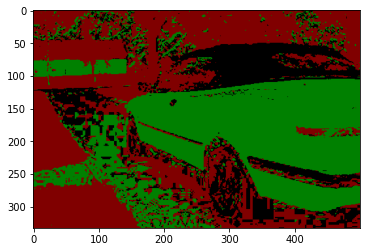

In [ ]:
# Changing the mode of the model to inference

fcn32_net.load_state_dict(torch.load('/content/fcn32_net.pth'))
fcn32_net.eval()

color_map = np.array(VOC_COLORMAP)
inference = run_inference('/content/VOCdevkit/VOC2007/JPEGImages/000007.jpg')

img = masktoimage(inference, color_map)
plt.imshow(img.astype(np.uint8))
print("Inferenced Segmentation mask")

Inferenced Image


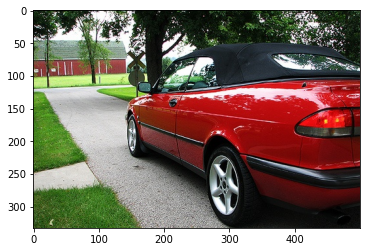

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread('/content/VOCdevkit/VOC2007/JPEGImages/000007.jpg'), cv2.COLOR_BGR2RGB))
print("Inferenced Image")

* **Properties of the segmentation model :**



1.   CNN based segmentation models can be interpreted as a combination of an encoder network, and a decoder network. 
2.   FCN32 is a fully convolutional network architecture used for image segmentation which can dynamically take different sized inputs and give corresponding outputs.
3. FCN32 differs from FCN8 and FCN16 on how much the encoder compresses the input before the decoder starts decompressing the output from the encoder. In the case of FCN32, the output from the encoder has to be upsampled by 32 times before it has the same dimensions as the input to the encoder.
4. In the case of this assignment's implementation, a pre-trained VGG16 network with batch normalization with its fully connected layer removed was used as the encoder network, and the decoder network was created in the FCN32 class.
5. However owing to a deep network, there are high number of trainable parameters which makes the training a time consuming process even when Pytorch uses CUDA. 


* **Evaluation metric (IoU) for segmentation model :** 


1.   The IoU metric (Intersection-over-Union) is used to evaluate the performance of Image Segmentation models.
2.   The basic idea of the metric is to evaluate how much of the predicted mask for a class in an image actually overlaps the ground truth segmentation mask for that image.
3. An IoU of 1 for a class in an image means that the predicted mask has a 100% overlap over the ground truth segmentation mask. Higher the IoU, better the performance of the segmentation model.
4. IoU is a powerful metric, because gives a quantitative measure which takes both false positives (predicted pixels that do not correspond to the ground truth) and false negatives (ground-truth pixels that are not predicted by the model) into account.

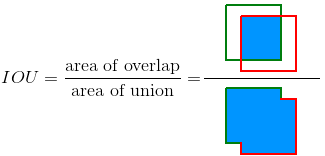



## Hint
* Refer to original paper FCNet : https://arxiv.org/abs/1411.4038
* Figures for FCNet Structure: https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
* PyTorch Tutorial for Image semgnetation: https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f